In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize


In [37]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'Ready1'
runName='TestRun1'
region='himalayas'

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)


#Setup the bounding box
minX=500000
maxX=600000
minY=0
maxY=100000
bbx = query.getDataSetBoundingBox(parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":400000,"gridCellMaxX":800000,"gridCellMinY":0,"gridCellMaxY":100000,"minTime":1279306567,"maxTime":1556036317,"totalPoints":86632,"numberOfShards":3}


In [66]:

print(parentDsName,dataset,region,minX,maxX,minY,maxY,minT,maxT,[],[])
fp = query.executeQuery( parentDsName,dataset,region,minX,maxX,minY,maxY,minT,maxT,[],[])
df = MalardHelpers.getDataFrameFromNetCDF(fp)

mtngla Ready1 himalayas 500000 600000 0 100000 2010-07-16 18:56:07 2019-04-23 16:18:37 [] []


In [63]:
df.shape

(83279, 34)

In [10]:
df.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'refElevation', 'refDifference'],
      dtype='object')

In [40]:
size=100000
year = []
month = []
yearmonth = []
day = []
dateobject = []
xdiff = []
ydiff = []
# glacial year
gla_year = []
for i, row in df.iterrows():
    date = datetime.datetime.utcfromtimestamp(df.time[i])
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    dateobject.append(date)
    yearmonth.append('%s-%s' % (date.year, date.month))
    # x and y distance to center point of gridcell
    xdiff.append((df.x[i] % size) - (size/2))
    ydiff.append((df.y[i] % size) - (size/2))
    if date.month < 10:
        gla_year.append(date.year)
    else:
        gla_year.append(date.year+1)
    
df['year'] = year
df['gla_year'] = gla_year
df['month'] = month
df['day'] = day
df['dateobject'] = dateobject
df['yearmonth'] = yearmonth
df['offsetX'] = xdiff
df['offsetY'] = ydiff
#df[df.columns[10:25]]

<IPython.core.display.Javascript object>


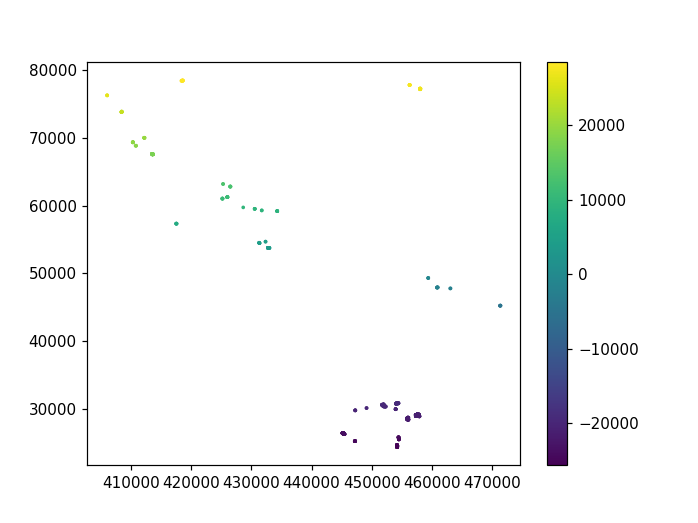

In [13]:
%matplotlib notebook
plt.scatter(x=df.x, y=df.y, c=df.offsetY, marker='.', s=8)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


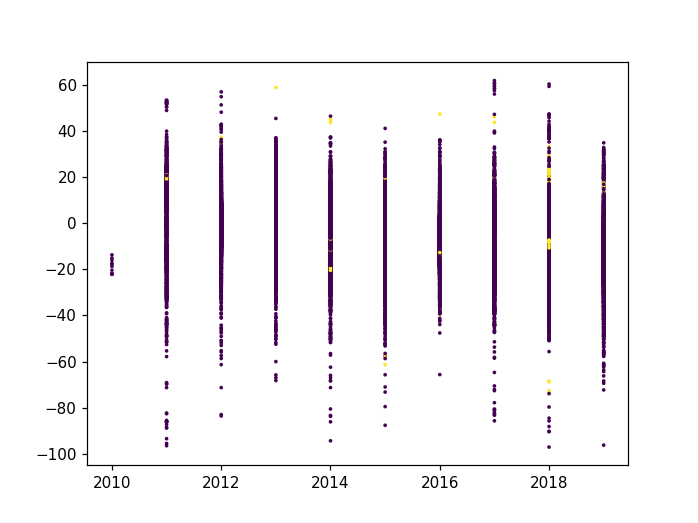

In [41]:
%matplotlib notebook
plt.scatter(x=df.gla_year, y=df.refDifference, c=df.within_Debris, marker='.', s=8, label=['debris', 'no-debris'])
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


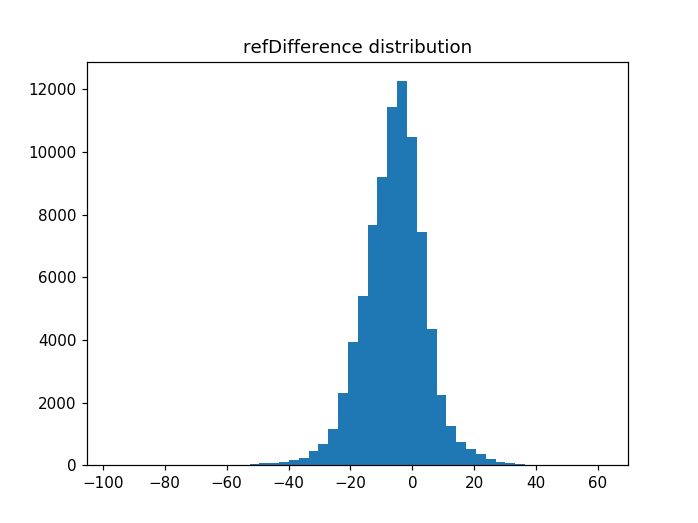

In [42]:
%matplotlib notebook
plt.hist(df.refDifference, bins=50)
plt.title('refDifference distribution')
plt.show()

<IPython.core.display.Javascript object>


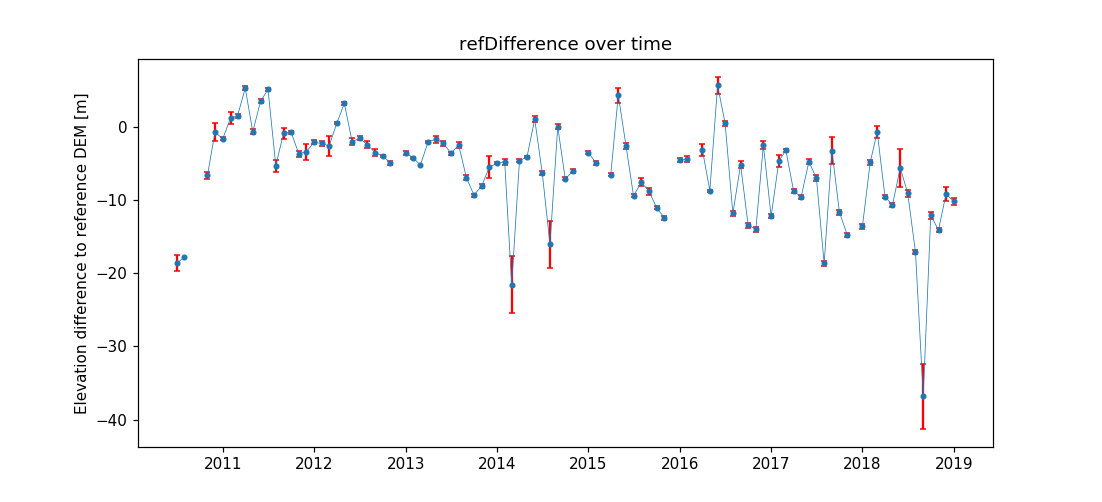

In [43]:
%matplotlib notebook
from dateutil.relativedelta import *
#averages = df.groupby(['year','month']).refDifference.mean()
averages = []
dates = []
errors = []

use_date = datetime.datetime(2010,1,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.month == use_date.month) & (df.year == use_date.year)]
    averages.append(df_filt.refDifference.mean())
    dates.append(use_date)
    errors.append(df_filt.refDifference.sem())
    #df_filt = df.query('month=%s && year=%s'  % (use_date.month, use_date.year))
    use_date = use_date+relativedelta(months=+1)

plt.errorbar(x=dates, y=averages, yerr=errors, marker='.', ecolor='red', elinewidth=1.5, capsize=2, linewidth=0.5)
plt.title('refDifference over time')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()

In [44]:
df_filtered = df[(df.gla_year > 2010) & (df.gla_year < 2019)]

coefficient of determination: 0.1412132180914265
intercept: 3569.4222701163044
slope: [-1.77471222]


<IPython.core.display.Javascript object>


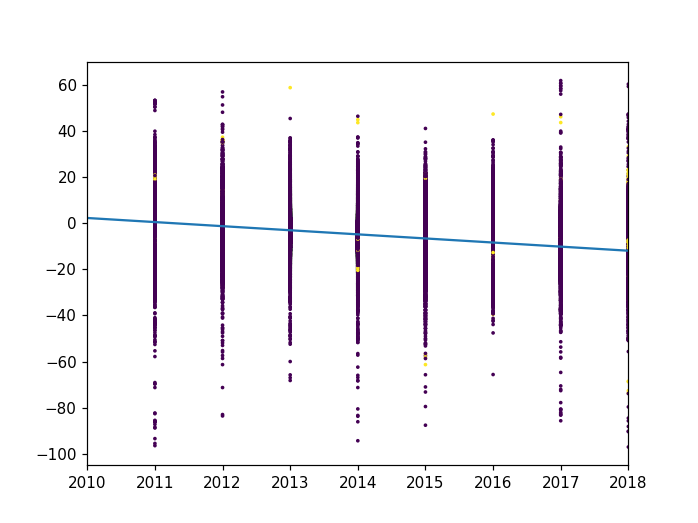

In [50]:
# linear regression with scikit
# step 1 import packages
%matplotlib notebook
import numpy as np
from sklearn.linear_model import LinearRegression

# step 2 - provide data
#vals = np.asarray([df_filtered.gla_year.values, df_filtered.offsetX, df_filtered.offsetY])
vals = np.asarray([df_filtered.gla_year.values])
x = np.transpose(vals)
#x = (df.year.values).reshape((-1, 1))
y = df_filtered.refDifference
# step 3 - create model and fir it
model = LinearRegression().fit(x, y)

# step 4 - get results
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_) # b0
print('slope:', model.coef_) # b1

# predict cell centre
#predict = model.predict([[2010,0,0],[2011,0,0],[2012,0,0],[2013,0,0],[2014,0,0],[2015,0,0],[2016,0,0],[2017,0,0],[2018,0,0]])
predict = model.predict([[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018]])

years=[i for i in range(2010, 2019)]
plt.plot(years, predict)
#plt.scatter(x=df.time, y=df.refDifference, c=df.debris, marker='.', s=8)
plt.scatter(x=df_filtered.gla_year, y=df_filtered.refDifference, c=df_filtered.within_Debris, marker='.', s=8)
plt.xlim(2010, 2018)
plt.show()

In [65]:
# linear regression with statsmodel
# step 1 import packages
import statsmodels.api as sm

# step 2 - provide data
vals = np.asarray([df_filtered.gla_year.values, df_filtered.offsetX, df_filtered.offsetY])
x = np.transpose(vals)
#x = (df.year.values- 2010).reshape((-1, 1))
y = df_filtered.refDifference
x = sm.add_constant(x)

# step 3 - create model and fit it (least squares)
#model = sm.RLM(y, x)
model = sm.OLS(y, x)
results = model.fit()
print(results.params)
print(results.params.x1)
print(results.bse.x1)
print(dir(results))
# step 4 - get results
results.summary()

const    3518.141934
x1         -1.747352
x2          0.000127
x3          0.000034
dtype: float64
-1.74735189469506
0.015528423086647078
['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_data_attr', '_get_robustcov_results', '_is_nested', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          refDifference   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     4780.
Date:                Wed, 31 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:36:25   Log-Likelihood:            -2.8969e+05
No. Observations:               79047   AIC:                         5.794e+05
Df Residuals:                   79043   BIC:                         5.794e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3518.1419     31.276    112.486      0.000    3456.841    3579.443
x1            -1.7474      0.016   -112.526      0.000      -1.778      -1.717
x2             0.0001   4.21e-06     30.053      0.000       0.000       0.000
x3           3.42e-05   3.36e-06     10.172      0.000    2.76e-05    4.08e-05
==============================================================================
Omnibus:                    11517.011   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129412.069
Skew:                          -0.326   Prob(JB):                         0.00
Kurtosis:                       9.234   Cond. No.                     3.22e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>


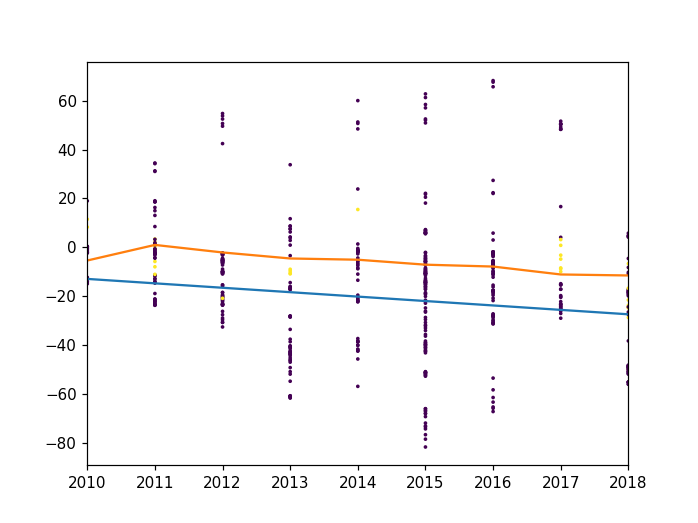

In [29]:
%matplotlib notebook
plt.plot(years, predict)
#plt.scatter(x=df.time, y=df.refDifference, c=df.debris, marker='.', s=8)
plt.scatter(x=df.year, y=df.refDifference, c=df.within_Debris, marker='.', s=8)
plt.xlim(2010, 2018)
plt.show()

In [30]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx_filtered
0,400000,0,100000,1.800890,164.495799,559,-15.102616,33,445452.991243,39138.013820,...,-8.099539,-28.367860,-11.581904,-19.933738,-12.577619,-2.202863,-31.617558,-15.910231,559,2217638
1,500000,0,100000,9.362339,762.097302,84381,-5.871442,395,525800.639277,27433.554758,...,-2.112782,-4.580646,-5.089044,-7.117132,-7.885725,-11.130472,-11.537673,-10.002011,84381,2104000


In [34]:
# get means
means=[]
years=[i for i in range(2010, 2019)]
for i in years:
    means.append(dfStats['statistics.result_refDifference_%s'% i ][1])

<IPython.core.display.Javascript object>


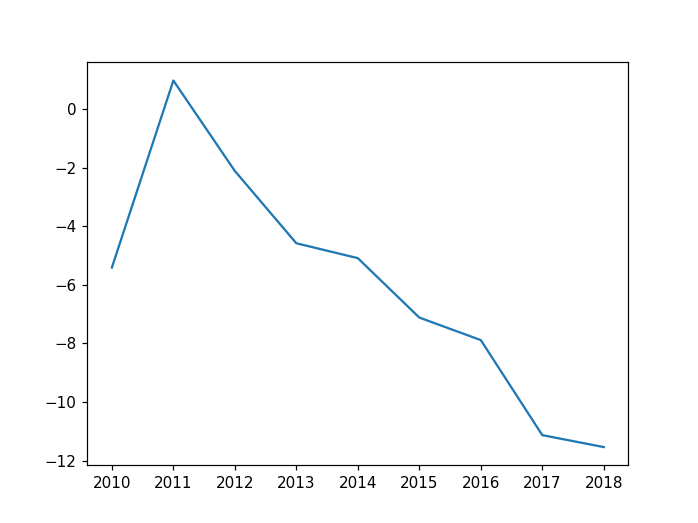

In [36]:
%matplotlib notebook
plt.plot(years, means)